# Running Ratio of EUV Wave Images

In this notebook, we'll demonstrate how to compute the running ratio for various EUV images in order to visualize the resulting EUV wave from the September 10th 2017 flaring event. This notebook partially follows the analysis of [Liu et al. (2018)](https://doi.org/10.3847/2041-8213/aad77b).

In [1]:
import glob
import warnings
import sys
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from scipy.ndimage import shift
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.wcs
import sunpy.map
from sunpy.instr.aia import aiaprep
from sunpy.util.metadata import MetaDict
import sunpy.physics.differential_rotation
import ndcube

import aiacube
from aiacube.util import futures_to_maps,maps_to_cube

sys.path.append('../scripts/')
from drms_on_ames import Client

plt.rcParams['animation.embed_limit'] = 500

%matplotlib inline

In [2]:
SCRATCH = '/nobackupp13/wtbarnes'

In [3]:
# Consider using differential rotation?
def derotate(smap, ref_map=None, rot_type='snodgrass'):
    new_coord = sunpy.physics.differential_rotation.solar_rotate_coordinate(
        smap.center, observer=ref_map.observer_coordinate, rot_type=rot_type)
    # Calculate shift
    x_shift = (new_coord.Tx - ref_map.center.Tx)/smap.scale.axis1
    y_shift = (new_coord.Ty - ref_map.center.Ty)/smap.scale.axis2

    # TODO: implement in Dask
    data_shifted = shift(smap.data, [y_shift.value, x_shift.value])

    # Update metadata
    new_meta = copy.deepcopy(smap.meta)
    # TODO: Should any keywords be updated here?
    return sunpy.map.Map(data_shifted, new_meta)

In [4]:
def normalize_to_exposure_time(smap):
    exptime = smap.meta['exptime'] if smap.meta['exptime'] != 0.0 else 2.9
    return sunpy.map.Map(smap.data / exptime, smap.meta)

## Query Data from Local netDRMS Instance

In [5]:
c = Client(ssh=True)

In [6]:
q = c.query(
    'aia_test.lev1_12s4arc[2017-09-10T15:30:00/2h][171,193,211]',
    seg=['image_lev1'],
)
files = q.values.squeeze().tolist()  # Is there a cleaner way to do this?

../scripts/drms_on_ames.py:57: UserWarning: 
-------------------------------------------------------------------------

By accessing and using this information system, you acknowledge and
consent to the following:

You are accessing a U.S. Government information system, which includes:
(1) this computer; (2) this computer network; (3) all computers connected
to this network including end user systems; (4) all devices and storage
media attached to this network or to any computer on this network; and
(5) cloud and remote information services. This information system is
provided for U.S. Government-authorized use only. You have no reasonable
expectation of privacy regarding any communication transmitted through or
data stored on this information system.  At any time, and for any lawful
purpose, the U.S. Government may monitor, intercept, search, and seize
any communication or data transiting, stored on, or traveling to or from
this information system.  You are NOT authorized to process cl

## Dask Cluster
Now spin up compute cluster with Dask

In [7]:
cluster = PBSCluster(
    cores=12,
    processes=1,
    memory="48GB",
    interface="ib0",
    resource_spec='select=1:ncpus=12',
    walltime='01:00:00',
    job_extra=['-W group_list=n1902'],
    queue='normal',
    local_directory=os.path.join(SCRATCH, 'dask-tmp'),
    log_directory=os.path.join(SCRATCH, 'dask-tmp'),
)

In [8]:
client = distributed.Client(cluster)

In [9]:
client

<Client: scheduler='tcp://10.152.4.0:35526' processes=0 cores=0>

In [10]:
cluster.scale_up(30) 

## Data Preparation
Call `aiaprep` and `derotate` on each frame

In [11]:
fmaps = client.map(sunpy.map.Map, files, pure=True)

In [12]:
fmaps_prep = client.map(aiaprep, fmaps, pure=True)

In [13]:
fmaps_prep_norm = client.map(
    normalize_to_exposure_time,
    fmaps_prep,
    pure=True,
)

In [14]:
fmaps_prep_norm_derot = client.map(
    derotate,
    fmaps_prep_norm,
    pure=True,
    ref_map=fmaps_prep_norm[0],
    rot_type='snodgrass'
)

Worker tcp://10.152.19.41:43290 restart in Job 622702. This can be due to memory issue.
Worker tcp://10.152.19.36:39068 restart in Job 622697. This can be due to memory issue.
Worker tcp://10.152.19.38:43924 restart in Job 622699. This can be due to memory issue.
Worker tcp://10.152.19.33:39340 restart in Job 622696. This can be due to memory issue.
Worker tcp://10.152.19.40:41937 restart in Job 622701. This can be due to memory issue.
Worker tcp://10.152.19.39:38345 restart in Job 622700. This can be due to memory issue.
Worker tcp://10.152.19.37:35408 restart in Job 622698. This can be due to memory issue.


In [15]:
client.cancel(fmaps)

In [18]:
maps_cluster = futures_to_maps(fmaps_prep_norm_derot)

## Data Cubes
Load into data cubes now that all of our frames are aligned.

In [19]:
cube_171 = maps_to_cube([m for m in maps_cluster if m.meta['wavelnth']==171])

Changed DATE-OBS from '2017-09-10 15:30:09.350' to '2017-09-10T15:30:09.350''. [astropy.wcs.wcs]


In [20]:
cube_171

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  12.00000000000188  
NAXIS : 4096  4096  450
---------------------
Length of NDCube: [ 450. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [21]:
cube_171.data

dask.array<stack, shape=(450, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096)>

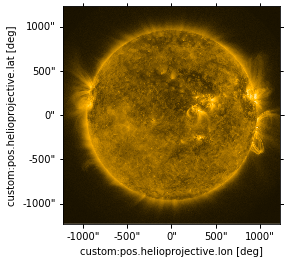

In [23]:
cube_171[0,:,:].plot(**maps_cluster[0].plot_settings)

In [24]:
cube_193 = maps_to_cube([m for m in maps_cluster if m.meta['wavelnth']==193])

Changed DATE-OBS from '2017-09-10 15:30:04.840' to '2017-09-10T15:30:04.840''. [astropy.wcs.wcs]


In [25]:
cube_211 = maps_to_cube([m for m in maps_cluster if m.meta['wavelnth']==211])

Changed DATE-OBS from '2017-09-10 15:29:57.630' to '2017-09-10T15:29:57.630''. [astropy.wcs.wcs]


## Running Ratio Analysis

Compute the running ratio for the 171, 193, and 211 Å channels.

In [26]:
window = 10

First, we'll rechunk our array in increments of the window along the time-axis and a single chunk over latitude and longitude. When doing the windowing, this means, we're only accessing a maximum of two chunks for any given operation which should alleviate the amount of data we are transferring between workers in the cluster.

We'll drop the `NDCube` container for now and just work with bare arrays.

In [27]:
data_171 = cube_171.data.rechunk((window,) + cube_171.data.shape[1:])

In [28]:
data_171

dask.array<rechunk-merge, shape=(450, 4096, 4096), dtype=float64, chunksize=(10, 4096, 4096)>

In [64]:
data_193 = cube_193.data.rechunk((window,) + cube_193.data.shape[1:])

In [65]:
data_211 = cube_211.data.rechunk((window,) + cube_211.data.shape[1:])

Now that we've rechunked the data, we'll compute the running ratio with a 2-minute window.

Next, compute the numerator and denominator for the ratio and take the $\log$ for each channel.

In [67]:
def running_ratio_with_window(data,w=1):
    num = da.stack([data[i:(i + w),:,:].sum(axis=0)
                    for i in range(w, data.shape[0] - w)])
    num[num<1.0] = 1.0
    denom = da.stack([data[(i - w):i, :, :].sum(axis=0)
                      for i in range(w, data.shape[0] - w)])
    denom[denom<1.0] = 1.0
    return da.log(num/denom)

In [68]:
ratio_171 = running_ratio_with_window(data_171,w=window)

In [69]:
ratio_193 = running_ratio_with_window(data_193,w=window)

In [70]:
ratio_211 = running_ratio_with_window(data_211,w=window)

If we want to calculate one of these, but leave it in the memory of the cluster (as opposed to bringing it into the notebook), we can use the `client.persist` method.

We'll add one more rechunk to make retrieving full images more efficient.

In [78]:
ratio_171 = ratio_171.rechunk((1,) + ratio_171.shape[1:])

In [79]:
ratio_171_mem = client.persist(ratio_171)

In [87]:
ratio_193 = ratio_193.rechunk((1,) + ratio_193.shape[1:])

In [88]:
ratio_193_mem = client.persist(ratio_193)

In [80]:
ratio_211 = ratio_211.rechunk((1,) + ratio_211.shape[1:])

In [81]:
ratio_211_mem = client.persist(ratio_211)

## Visualize

Lastly, let's animate this over the entire two-hour interval using matplotlib. 

In [82]:
def make_running_ratio_animation(data, cmap='Greys', vmin=-.1, vmax=.1, delta_frames=10):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    im = ax.imshow(np.flipud(data[0,:,:]),
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,)
    def update_plot(i):
        im.set_data(np.flipud(data[i,:,:]))
    ani = matplotlib.animation.FuncAnimation(
        fig,
        update_plot,
        frames=range(1,data.shape[0],delta_frames),
        #blit=True,
    )
    return ani

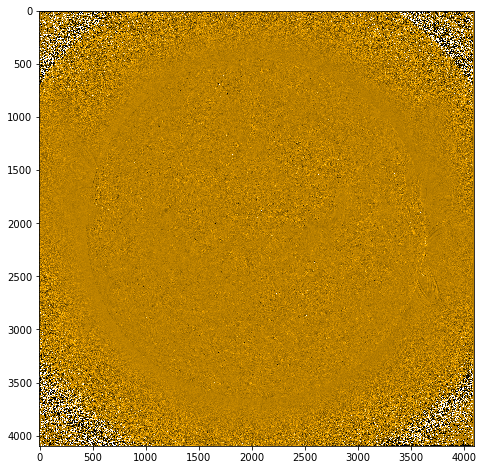

In [94]:
ani_171 = make_running_ratio_animation(
    ratio_171_mem,
    cmap=sunpy.cm.color_tables.aia_color_table(171),
    vmin=-0.5,
    vmax=0.5,
    delta_frames=5,
)

In [ ]:
HTML(ani_171.to_jshtml())

In [ ]:
ani_193 = make_running_ratio_animation(
    ratio_193_mem,
    cmap=sunpy.cm.color_tables.aia_color_table(193),
    vmin=-0.5,
    vmax=0.5,
)

In [ ]:
HTML(ani_193.to_jshtml())

In [ ]:
ani_211 = make_running_ratio_animation(
    ratio_211_mem,
    cmap=sunpy.cm.color_tables.aia_color_table(211),
    vmin=-0.5,
    vmax=0.5,
)

In [ ]:
HTML(ani_211.to_jshtml())